In [1]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
import pandas as pd
pd.__version__

'0.24.2'

In [3]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [5]:
# dataset path
dataset_path = './csv/diff_dataset.csv'
testset_path = './csv/diff_testset.csv'

In [6]:
# read dataset
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [7]:
# drop unnamed column
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
# remove resolve state
data_drop_index = dataset[dataset['v_type_code'] %2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] %2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

# data_57 = dataset[dataset['v_type_code'].isin([5,7])].index.tolist()
# dataset.drop(index=data_57, axis=0, inplace=True)

# test_57 = testset[testset['v_type_code'].isin([5,7])].index.tolist()
# testset.drop(index=test_57, axis=0, inplace=True)

In [9]:
# Try to combine 5 and 7 into one type.
dataset['v_type_code'] = dataset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)
testset['v_type_code'] = testset['v_type_code'].apply(lambda x: 57 if x == 5 or x == 7 else x)

In [10]:
print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

column = dataset.columns

dataset:
(930, 997)
testset:
(840, 997)


In [11]:
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1770, 996) (1770,)
(930, 996) (930,)
(840, 996) (840,)


In [12]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

In [13]:
# XGBoost
def xgboost(X_train, y_train, X_test, y_test, show=False, plt_show=True):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=100, objective='multi:softprob', num_class=5, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()
    y_pred = xgb.predict(X_test)
    current_time = time.time()
    accuracy_score(y_test, y_pred)

#     print("train time： {}".format(middle_time - last_time))
#     print("test time： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        report=classification_report(y_test, y_pred, output_dict=True)
        report['train_time']=middle_time - last_time
        report['test_time']=current_time - middle_time
        return report

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
model = XGBClassifier(importance_type='gain',n_estimators=100)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

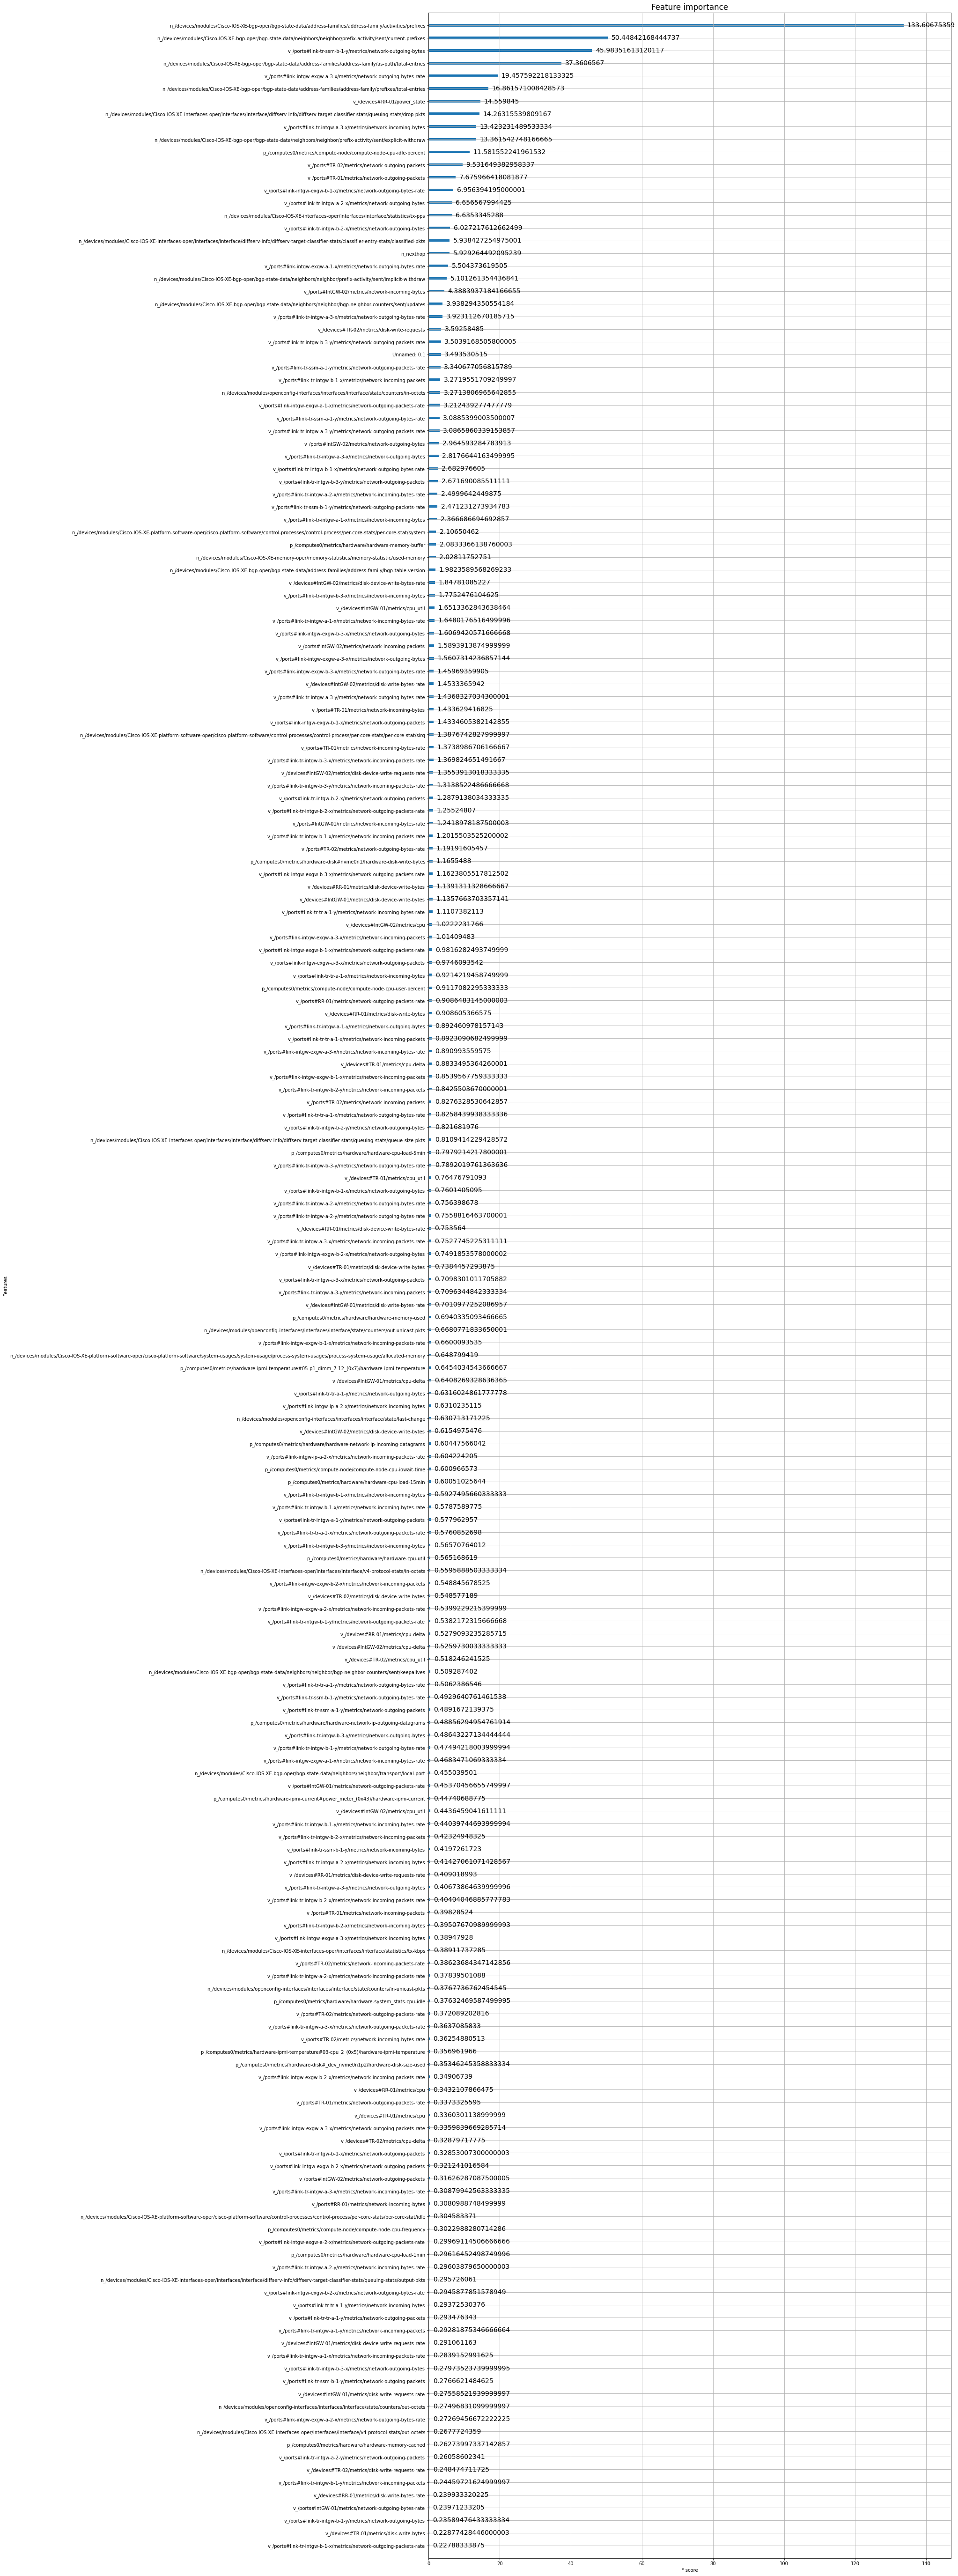

In [16]:
_, ax = plt.subplots(figsize=(20, 100))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14) 
plot_importance(model, ax=ax, max_num_features=200, importance_type='gain')
plt.show()

In [17]:
im=pd.DataFrame({'importance':model.feature_importances_,'var':X.columns})
im=im.sort_values(by='importance',ascending=False)
im.to_csv("feature_important_data_XG_1015.csv")

In [32]:
thresholds = sort(model.feature_importances_)[-200:]
print(thresholds)

[3.65470987e-05 3.74020274e-05 3.76504104e-05 5.23126037e-05
 5.69902477e-05 5.82336579e-05 6.23942033e-05 6.80091107e-05
 6.85951381e-05 6.87739739e-05 6.92234680e-05 7.00225501e-05
 7.17998992e-05 7.35562426e-05 7.59052709e-05 8.16353495e-05
 8.19050692e-05 8.21048234e-05 8.48126656e-05 8.48549680e-05
 8.75894038e-05 8.99669321e-05 9.13911281e-05 9.51070979e-05
 1.00428493e-04 1.07281616e-04 1.17230455e-04 1.22370853e-04
 1.33550449e-04 1.35335082e-04 1.40854972e-04 1.45863130e-04
 1.47560408e-04 1.50989290e-04 1.54011679e-04 1.55403541e-04
 1.56873823e-04 1.68464991e-04 1.69990453e-04 1.70054336e-04
 1.74113928e-04 1.76304020e-04 1.93381231e-04 1.93737171e-04
 1.94632332e-04 2.00437964e-04 2.09929072e-04 2.12099680e-04
 2.14130559e-04 2.18793721e-04 2.19651178e-04 2.21041191e-04
 2.26719989e-04 2.27185999e-04 2.27416138e-04 2.28352204e-04
 2.28950841e-04 2.29204394e-04 2.33624363e-04 2.34833162e-04
 2.37038214e-04 2.38432651e-04 2.39569184e-04 2.41713744e-04
 2.43564733e-04 2.474309

In [33]:
list_1=[]
list_3=[]
list_5_7=[]
# list_5=[]
# list_7=[]
list_9=[]
list_11=[]
list_acc=[]
list_train_time=[]
list_test_time=[]

for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # 格式：'1': {'precision': 0.9824561403508771, 'recall': 0.875, 'f1-score': 0.9256198347107438, 'support': 64}
    report = xgboost(select_X_train, y_train, select_X_test, y_test,show=True)
    list_1.append(report['1']['precision'])
    list_3.append(report['3']['precision'])
#     list_5.append(report['5']['precision'])
#     list_7.append(report['7']['precision'])
    list_5_7.append(report['57']['precision'])
    list_9.append(report['9']['precision'])
    list_11.append(report['11']['precision'])
    list_train_time.append(report['train_time'])
    list_test_time.append(report['test_time'])
    list_acc.append(report['accuracy'])
    print("Thresh=%.4f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], report['accuracy'] * 100.0))

Thresh=0.0000, n=300, Accuracy: 93.33%
Thresh=0.0000, n=299, Accuracy: 93.45%
Thresh=0.0000, n=298, Accuracy: 93.45%
Thresh=0.0001, n=297, Accuracy: 93.45%
Thresh=0.0001, n=296, Accuracy: 93.45%
Thresh=0.0001, n=295, Accuracy: 93.45%
Thresh=0.0001, n=294, Accuracy: 93.45%
Thresh=0.0001, n=293, Accuracy: 93.45%
Thresh=0.0001, n=292, Accuracy: 93.33%
Thresh=0.0001, n=291, Accuracy: 93.10%
Thresh=0.0001, n=290, Accuracy: 93.45%
Thresh=0.0001, n=289, Accuracy: 93.33%
Thresh=0.0001, n=288, Accuracy: 93.33%
Thresh=0.0001, n=287, Accuracy: 93.33%
Thresh=0.0001, n=286, Accuracy: 93.45%
Thresh=0.0001, n=285, Accuracy: 93.33%
Thresh=0.0001, n=284, Accuracy: 93.33%
Thresh=0.0001, n=283, Accuracy: 93.33%
Thresh=0.0001, n=282, Accuracy: 93.45%
Thresh=0.0001, n=281, Accuracy: 93.33%
Thresh=0.0001, n=280, Accuracy: 93.33%
Thresh=0.0001, n=279, Accuracy: 93.45%
Thresh=0.0001, n=278, Accuracy: 93.45%
Thresh=0.0001, n=277, Accuracy: 93.45%
Thresh=0.0001, n=276, Accuracy: 93.45%
Thresh=0.0001, n=275, Acc

Thresh=0.0013, n=89, Accuracy: 93.81%
Thresh=0.0013, n=88, Accuracy: 93.81%
Thresh=0.0013, n=87, Accuracy: 93.81%
Thresh=0.0013, n=86, Accuracy: 93.81%
Thresh=0.0014, n=85, Accuracy: 93.81%
Thresh=0.0014, n=84, Accuracy: 93.81%
Thresh=0.0014, n=83, Accuracy: 93.81%
Thresh=0.0014, n=82, Accuracy: 93.69%
Thresh=0.0014, n=81, Accuracy: 93.81%
Thresh=0.0014, n=80, Accuracy: 93.81%
Thresh=0.0015, n=79, Accuracy: 93.81%
Thresh=0.0015, n=78, Accuracy: 93.81%
Thresh=0.0015, n=77, Accuracy: 93.81%
Thresh=0.0015, n=76, Accuracy: 93.81%
Thresh=0.0016, n=75, Accuracy: 93.81%
Thresh=0.0016, n=74, Accuracy: 93.69%
Thresh=0.0016, n=73, Accuracy: 93.93%
Thresh=0.0016, n=72, Accuracy: 93.81%
Thresh=0.0018, n=71, Accuracy: 93.81%
Thresh=0.0018, n=70, Accuracy: 93.81%
Thresh=0.0018, n=69, Accuracy: 93.81%
Thresh=0.0019, n=68, Accuracy: 93.81%
Thresh=0.0019, n=67, Accuracy: 93.81%
Thresh=0.0019, n=66, Accuracy: 93.81%
Thresh=0.0019, n=65, Accuracy: 93.81%
Thresh=0.0020, n=64, Accuracy: 93.81%
Thresh=0.002

/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(len(list_1))

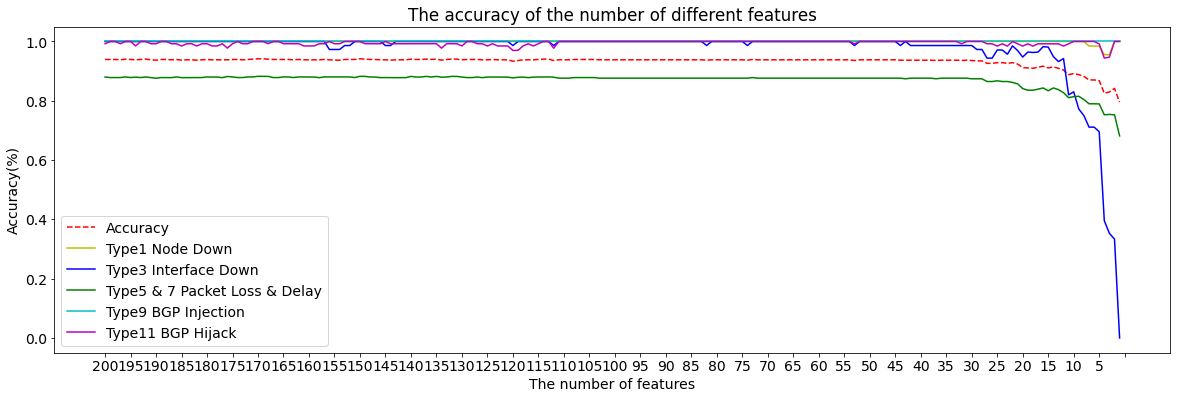

In [21]:
# X_train result
x_n = [str(200-x) for x in range(200)]
plt.figure(figsize=(20, 6))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14) 
plt.plot(x_n,list_acc,'r--',label='Accuracy')
plt.plot(x_n,list_1,'y',label='Type1 Node Down')
plt.plot(x_n,list_3,'b',label='Type3 Interface Down')
# plt.plot(x_n,list_5,'g',label='Type5 Packet Loss')
# plt.plot(x_n,list_7,'k',label='Type7 Packet Delay')
plt.plot(x_n,list_5_7,'g',label='Type5 & 7 Packet Loss & Delay')
plt.plot(x_n,list_9,'c',label='Type9 BGP Injection')
plt.plot(x_n,list_11,'m',label='Type11 BGP Hijack')
plt.legend(loc='lower left')
plt.title('The accuracy of the number of different features')
plt.xlabel('The number of features')
plt.ylabel('Accuracy(%)')
plt.xticks(np.arange(200,-5,-5))
plt.show()

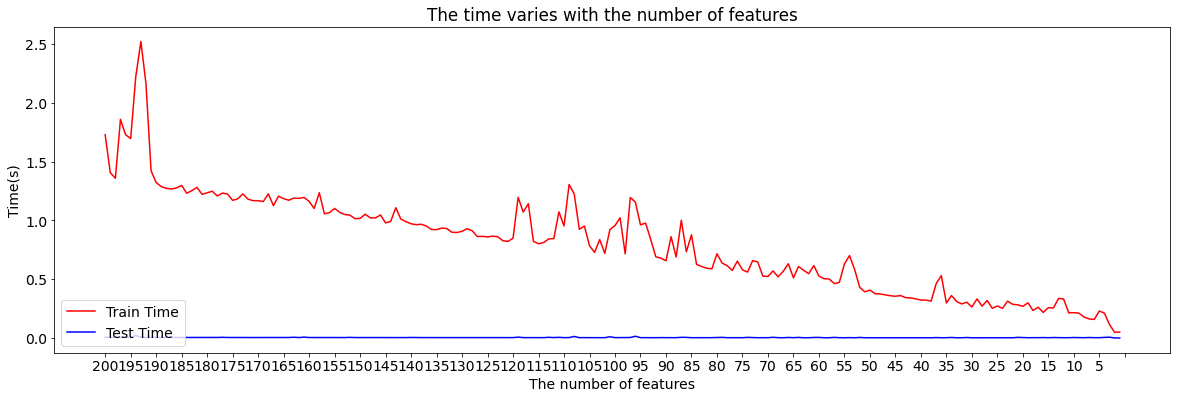

In [22]:
# time result
x_n = [str(200-x) for x in range(200)]
plt.figure(figsize=(20, 6))
plt.rc('font', size=14)
plt.rc('axes', labelsize=14) 
plt.plot(x_n,list_train_time,'r',label='Train Time')
plt.plot(x_n,list_test_time,'b',label='Test Time')
plt.legend(loc='lower left')
plt.title('The time varies with the number of features')
plt.xlabel('The number of features')
plt.ylabel('Time(s)')
plt.xticks(np.arange(200,-5,-5))
plt.show()

In [23]:
selection = SelectFromModel(model, threshold=0.0035, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

In [24]:
def xgboost_show_cm(X_train, y_train, X_test, y_test):
    last_time = time.time()
    xgb = XGBClassifier(num_class=5, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    print("XGBOOST Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix xgb:')
    print(cm)
    print('classification report xgb:')
    print(classification_report(y_test, y_pred))

In [25]:
xgboost_show_cm(X_train, y_train, X_test, y_test)

XGBOOST Accuracy: 0.93
train time： 5.633549928665161
test time： 0.038285017013549805
confusion matrix xgb:
[[ 62   0   0   2   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 129  50]
 [  0   0   0   2 366]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       0.97      0.72      0.82       180
          57       0.88      0.99      0.93       368

    accuracy                           0.93       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.93      0.93       840



In [26]:
xgboost_show_cm(select_X_train, y_train, select_X_test, y_test)

XGBOOST Accuracy: 0.94
train time： 0.3332650661468506
test time： 0.0037908554077148438
confusion matrix xgb:
[[ 64   0   0   0   0]
 [  0  72   0   0   0]
 [  0   0 156   0   0]
 [  0   1   0 127  52]
 [  0   0   0   0 368]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      1.00      0.99        72
           9       1.00      1.00      1.00       156
          11       1.00      0.71      0.83       180
          57       0.88      1.00      0.93       368

    accuracy                           0.94       840
   macro avg       0.97      0.94      0.95       840
weighted avg       0.94      0.94      0.93       840



In [27]:
print(list_acc[143])
print(list_1[143])
print(list_3[143])
print(list_5_7[143])
print(list_9[143])
print(list_11[143])

0.9380952380952381
1.0
1.0
0.8761904761904762
1.0
1.0


In [ ]:
from sklearn.decomposition import PCA

In [43]:
pca=PCA(n_components=30)     #加载PCA算法，设置降维后主成分数目为自动
reduced_X=pca.fit_transform(X)#对样本进行降维


In [44]:
# random forest
def random_forest(X_train, y_train, X_test, y_test, show=False):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()

    print("Accuracy: %.2f"% accuracy_score(y_test, y_pred))

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    if show:
        cm = confusion_matrix(y_test, y_pred)
        print('confusion matrix rf:')
        print(cm)
        print('classification report rf:')
        print(classification_report(y_test, y_pred))

        plot_confusion_matrix(cm, classes=['1', '3', '9', '11'],
                              normalize=True, title='Normalized confusion matrix')

        plt.show()

Accuracy: 0.79
训练耗时： 0.16594672203063965
测试耗时： 0.012247085571289062
confusion matrix rf:
[[ 63   0   0   2]
 [  8  78  35   0]
 [  1  18 158   2]
 [  1   4  40 110]]
classification report rf:
              precision    recall  f1-score   support

           1       0.86      0.97      0.91        65
           3       0.78      0.64      0.71       121
           9       0.68      0.88      0.77       179
          11       0.96      0.71      0.82       155

    accuracy                           0.79       520
   macro avg       0.82      0.80      0.80       520
weighted avg       0.81      0.79      0.79       520

Normalized confusion matrix
[[0.96923077 0.         0.         0.03076923]
 [0.0661157  0.6446281  0.2892562  0.        ]
 [0.00558659 0.10055866 0.88268156 0.01117318]
 [0.00645161 0.02580645 0.25806452 0.70967742]]


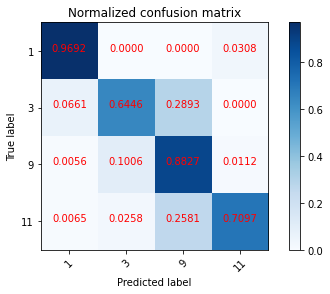

In [45]:
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, Y, test_size=0.7)
random_forest(reduced_X_train, reduced_y_train, reduced_X_test, reduced_y_test, show=True)

In [28]:
from lightgbm import LGBMClassifier

def gbm_show_cm(X_train, y_train, X_test, y_test):
    last_time = time.time()
    
    gbm = LGBMClassifier(learning_rate=0.1, n_estimators=40)
    gbm.fit(X_train, y_train)

    middle_time = time.time()

    y_pred = gbm.predict(X_test)

    current_time = time.time()

    print("GBM Accuracy: %.2f" % accuracy_score(y_test, y_pred))
    print("train time： {}".format(middle_time - last_time))
    print("test time： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix gbm:')
    print(cm)
    print('classification report gbm:')
    print(classification_report(y_test, y_pred))
    # 特征重要度
    print('Feature importances:', list(gbm.feature_importances_))
    
    # 网格搜索，参数优化 learning_rate=0.1, n_estimators=40
#     estimator = LGBMClassifier(num_leaves=31)
#     param_grid = {
#         'learning_rate': [0.01, 0.1, 1],
#         'n_estimators': [20, 40]
#     }
#     gbm = GridSearchCV(estimator, param_grid)
#     gbm.fit(X_train, y_train)
#     print('Best parameters found by grid search are:', gbm.best_params_)
    


In [29]:
import re
X_train_gbm = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
X_test_gbm = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))

gbm_show_cm(X_train_gbm, y_train, X_test_gbm, y_test)

GBM Accuracy: 0.93
train time： 2.81748628616333
test time： 0.17267608642578125
confusion matrix gbm:
[[ 64   0   0   0   0]
 [  0  70   0   0   2]
 [  0   0 156   0   0]
 [  0   1   0 126  53]
 [  0   0   0   0 368]]
classification report gbm:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           3       0.99      0.97      0.98        72
           9       1.00      1.00      1.00       156
          11       1.00      0.70      0.82       180
          57       0.87      1.00      0.93       368

    accuracy                           0.93       840
   macro avg       0.97      0.93      0.95       840
weighted avg       0.94      0.93      0.93       840

Feature importances: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 27, 35, 0, 3, 0, 20, 6, 31, 10, 2, 19, 6, 5, 0, 0, 10, 15, 0, 0, 0, 26, 11, 39, 33, 0, 4, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 